LightGBM: es un marco de mejora de gradientes que utiliza algoritmos de aprendizaje basados en árboles.
Este código se utiliza para entrenar y evaluar un modelo de detección de fraudes utilizando LightGBM y un conjunto de datos en formato CSV.

In [42]:
# Tratamiento de datos
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix


# Modelado y Forecasting
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_score



In [43]:
# Función para optimizar tipos de datos
def optimize_memory(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

Esta función reduce el uso de memoria convirtiendo columnas de tipo int64 a int32 y float64 a float32.

In [44]:
# Cargar el conjunto de datos
data = pd.read_csv('fraud_detection_dataset.csv')

# Optimizar tipos de datos
data = optimize_memory(data)


In [45]:
data.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.000000,160296.359375,M1979787155,0.0,0.000000,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.000000,19384.720703,M2044282225,0.0,0.000000,0,0
2,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.0,0.000000,1,0
3,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.0,0.000000,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.000000,29885.859375,M1230701703,0.0,0.000000,0,0
5,1,PAYMENT,7817.709961,C90045638,53860.000000,46042.289062,M573487274,0.0,0.000000,0,0
6,1,PAYMENT,7107.770020,C154988899,183195.000000,176087.234375,M408069119,0.0,0.000000,0,0
7,1,PAYMENT,7861.640137,C1912850431,176087.234375,168225.593750,M633326333,0.0,0.000000,0,0
8,1,PAYMENT,4024.360107,C1265012928,2671.000000,0.000000,M1176932104,0.0,0.000000,0,0
9,1,DEBIT,5337.770020,C712410124,41720.000000,36382.230469,C195600860,41898.0,40348.789062,0,0


In [46]:
data.dtypes

step                int32
type               object
amount            float32
nameOrig           object
oldbalanceOrg     float32
newbalanceOrig    float32
nameDest           object
oldbalanceDest    float32
newbalanceDest    float32
isFraud             int32
isFlaggedFraud      int32
dtype: object

In [47]:
list(data['type'].drop_duplicates())

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']

In [48]:
classificador_lgbm = lgb.LGBMClassifier()

In [49]:
type(classificador_lgbm)

lightgbm.sklearn.LGBMClassifier

In [50]:
# Muestreo aleatorio del dataset
# Toma una muestra aleatoria del 10% del conjunto de datos original para hacer el procesamiento más rápido.
sampled_data = data.sample(frac=0.1, random_state=42) 

# Codificar la columna 'type' usando One-Hot Encoding
# Realiza una codificación one-hot de la columna type, eliminando la primera categoría para evitar la multicolinealidad.
sampled_data = pd.get_dummies(sampled_data, columns=['type'], drop_first=True)

# Seleccionar características (X) y la etiqueta (y)
# Selecciona las características (X) eliminando las columnas isFraud, nameOrig, nameDest y isFlaggedFraud, y selecciona la etiqueta isFraud.
X = sampled_data.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
y = sampled_data['isFraud']

# Dividir el dataset en conjuntos de entrenamiento y prueba
# Divide el conjunto de datos en entrenamiento (80%) y prueba (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el dataset de LightGBM
# Crea objetos de tipo Dataset de LightGBM para los conjuntos de entrenamiento y prueba.
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar los parámetros del modelo
# Define los parámetros del modelo LightGBM, incluyendo el objetivo binario, la métrica de pérdida logarítmica binaria, 
# el tipo de boosting (Gradient Boosting Decision Trees), 
# el número de hojas, la tasa de aprendizaje y la fracción de características.
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Entrenar el modelo con early stopping
# Entrena el modelo LightGBM, utilizando un número máximo de 100 rondas de boosting y early stopping con 10 rondas de tolerancia.
gbm = lgb.train(params,
                train_data,
                num_boost_round=100,
                valid_sets=[train_data, test_data],
                callbacks=[lgb.early_stopping(stopping_rounds=10)])

# Hacer predicciones
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluar el modelo
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)

# Realiza predicciones sobre el conjunto de prueba, convierte las predicciones a valores binarios (0 o 1) usando un umbral de 0.5, 
# y evalúa el modelo calculando el ROC AUC y la exactitud, imprimiendo ambos valores.

print(f'ROC AUC Score: {roc_auc}')
print(f'Accuracy: {accuracy}')

[LightGBM] [Info] Number of positive: 643, number of negative: 508366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 509009, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001263 -> initscore=-6.672812
[LightGBM] [Info] Start training from score -6.672812
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00389469	valid_1's binary_logloss: 0.00475675
ROC AUC Score: 0.9604777705026097
Accuracy: 0.999339897684141


Este flujo de trabajo es bastante estándar para el entrenamiento y evaluación de modelos de clasificación binaria usando LightGBM, e incluye optimización de memoria, muestreo, codificación de variables categóricas, selección de características, división de datos, y evaluación del rendimiento del modelo.

A partir de los resultados proporcionados, podemos sacar varias conclusiones sobre el rendimiento del modelo LightGBM entrenado para la detección de fraudes:

- Hay un desbalance significativo entre las clases, con 643 instancias de fraude (positivas) y 508,366 instancias de no fraude (negativas). Esto puede afectar la capacidad del modelo para detectar correctamente las instancias de fraude debido a la prevalencia abrumadora de la clase negativa.


- LightGBM ha elegido automáticamente el procesamiento en paralelo por filas, lo que optimiza el tiempo de entrenamiento. Se sugiere que si la memoria no es suficiente, se puede cambiar a procesamiento por columnas.

- El modelo ha utilizado 1538 bins y 10 características en un conjunto de datos de entrenamiento con 509,009 puntos de datos.

- El modelo inicializa la puntuación con -6.672812, basada en la proporción de clases positivas.

- El entrenamiento se detuvo temprano después de 5 iteraciones debido a que las puntuaciones de validación no mejoraron en 10 rondas consecutivas. Esto sugiere que el modelo alcanzó su mejor rendimiento rápidamente, con una pérdida logarítmica binaria muy baja tanto en el conjunto de entrenamiento como en el de validación.

- Rendimiento del modelo:

    * ROC AUC Score: Un puntaje de 0.9605 indica que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas. Cuanto más cerca de 1, mejor es el rendimiento del modelo en términos de clasificación binaria.
    * Accuracy (Exactitud): Un valor de 0.9993 indica una alta precisión, lo que significa que el modelo predice correctamente casi todas las instancias. Sin embargo, dado el desbalance de clases, la exactitud puede ser engañosa, ya que un modelo que siempre predice la clase mayoritaria (no fraude) también tendría una alta exactitud.


In [51]:
# Visualizar la distribución de la variable objetivo
# Contar el número de fraudes y no fraudes
fraud_counts = sampled_data['isFraud'].value_counts().reset_index()
fraud_counts.columns = ['isFraud', 'count']
fraud_counts['isFraud'] = fraud_counts['isFraud'].map({0: 'Not Fraud', 1: 'Fraud'})

# Calcular los porcentajes
total = fraud_counts['count'].sum()
fraud_counts['percentage'] = (fraud_counts['count'] / total * 100).round(2)

# Crear el gráfico de barras
fig = px.bar(fraud_counts, x='isFraud', y='count', text='percentage',
             title='Número y Porcentaje de Fraudes vs. No Fraudes',
             labels={'isFraud': 'Class', 'count': 'Count', 'percentage': 'Percentage'},
             color='isFraud',
             color_discrete_map={'Not Fraud': 'lightcoral', 'Fraud': 'blue'})

# Actualizar el texto para mostrar el porcentaje
fig.update_traces(texttemplate='%{text}%')

# Mostrar la figura
fig.show()

In [52]:
# Obtener la importancia de las características
feature_importances = gbm.feature_importance()
feature_names = X_train.columns

# Crear un dataframe para facilitar el plot
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Crear la figura de Plotly para la importancia de las características
fig = px.bar(feature_imp_df, x='Importance', y='Feature', orientation='h', title='Características importantes')

# Invertir el eje y para que las características más importantes estén en la parte superior
fig.update_layout(yaxis=dict(autorange='reversed'))

# Mostrar la figura
fig.show()

In [53]:
# Calcular la frecuencia de los diferentes tipos de transacciones
transaction_freq = data['type'].value_counts().reset_index()
transaction_freq.columns = ['Transaction Type', 'Frequency']

# Crear el gráfico con Plotly Express
fig = px.bar(transaction_freq, x='Transaction Type', y='Frequency', 
             title='Frecuencia de Tipos de Transacciones',
             labels={'Transaction Type': 'Tipo de Transacción', 'Frequency': 'Frecuencia'})

# Mostrar el gráfico
fig.show()

La curva ROC nos permite visualizar la capacidad del modelo para distinguir entre las clases positivas y negativas.

In [54]:
# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Crear la figura de Plotly para la curva ROC
fig = go.Figure()

# Añadir la curva ROC
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})', line=dict(color='tomato', width=2)))

# Añadir la línea diagonal de referencia
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='royalblue', width=2, dash='dash'), showlegend=False))

# Configurar el diseño de la figura
fig.update_layout(title='Curva Característica de Funcionamiento del Receptor (ROC)',
                  xaxis_title='Tasa de falsos positivos',
                  yaxis_title='Tasa de verdaderos positivos',
                  showlegend=True)

# Mostrar la figura
fig.show()

La matriz de confusión nos muestra el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

In [55]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Definir los nombres de las etiquetas
labels = ['Not Fraud', 'Fraud']

# Crear la figura de Plotly para la matriz de confusión
fig = ff.create_annotated_heatmap(z=conf_matrix, x=labels, y=labels, colorscale='Blues', showscale=True)

# Añadir títulos y etiquetas
fig.update_layout(title='Confusion Matrix',
                  xaxis=dict(title='Predicted Label'),
                  yaxis=dict(title='True Label'))

# Mostrar la figura
fig.show()

In [56]:
# Calcular Precisión, Recall y F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.7616
Recall: 0.7529
F1-score: 0.7572


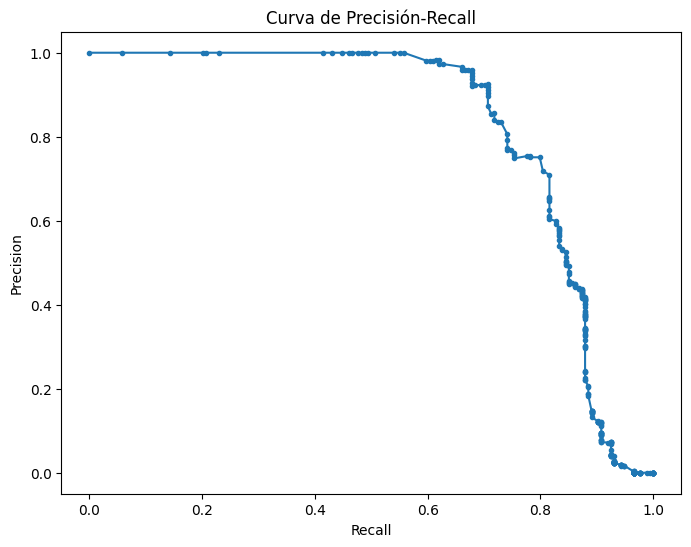

In [57]:
# Curva de Precisión-Recall (PRC)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.show()


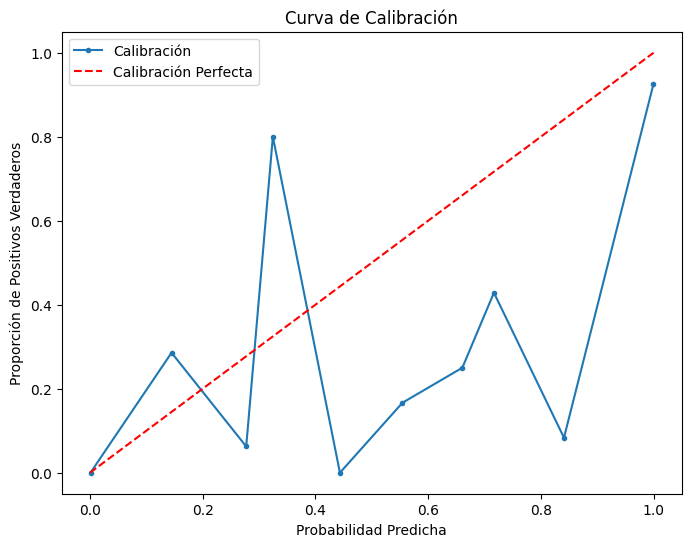

In [58]:
# Curva de Calibración
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='.', label='Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Calibración Perfecta')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Proporción de Positivos Verdaderos')
plt.title('Curva de Calibración')
plt.legend()
plt.show()

In [59]:
# Crear el modelo de LightGBM utilizando LGBMClassifier
# Se crea el modelo de LightGBM utilizando LGBMClassifier de Scikit-Learn, pasando los parámetros definidos anteriormente.
lgbm_classifier = LGBMClassifier(**params)

# Entrenar el modelo con LightGBM
lgbm_classifier.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgbm_classifier.predict(X_test)

# Calcular la precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión en conjunto de prueba: {test_accuracy:.4f}')

# Prueba de Robustez y Generalización
cv_scores = cross_val_score(lgbm_classifier, X, y, cv=5)
print('Cross-Validation Scores:', cv_scores)
print('Mean CV Score:', cv_scores.mean())



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 643, number of negative: 508366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 509009, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001263 -> initscore=-6.672812
[LightGBM] [Info] Start training from score -6.672812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Precisión en conjunto de prueba: 0.9992
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Curren

Se realiza una prueba de robustez y generalización utilizando validación cruzada (cross_val_score) con 5 folds (cv=5). Se calculan los puntajes de validación cruzada y se imprime en pantalla el puntaje de cada fold y el puntaje promedio (Mean CV Score). Esto ayuda a evaluar la capacidad de generalización del modelo más allá de un solo conjunto de entrenamiento y prueba.